# Data Science Workflow

## Set Up the Jupyter Notebook for Analysis

Note: We have our brand new package called swat - SAS Scripting Wrapper for Analytics Transfer - available on GitHub via pip install <br>
Copyright (c) 2017 SAS Institute Inc.

In [1]:
import swat
import os

In [2]:
### SAS Viya CAS Server connection details

os.environ['CAS_CLIENT_SSL_CA_LIST'] = '/opt/sas/viya/config/etc/SASSecurityCertificateFramework/cacerts/trustedcerts.pem'
cashost='frasepviya35smp.cloud.com'
casport=5570
casauth='~/.authinfo'

### Start CAS Session

s = swat.CAS(cashost, casport, authinfo=casauth)

In [3]:
s

CAS('frasepviya35smp.cloud.com', 5570, 'viyademo01', protocol='cas', name='py-session-1', session='cdd05183-263e-2747-aaf9-95471e8e3d33')

In [4]:
# Load actionsets for analysis (for data prep, modeling, assessing)
actionsets = ['cardinality', 'sampling', 'fedSQL', 'decisionTree', 'regression', 'neuralNet', 'svm', 'astore','autotune']
actions = [s.loadactionset(i) for i in actionsets]

NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'fedSQL'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'svm'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'autotune'.


## Access Data - CAS

In [6]:
# Define caslib
s.sessionprop.setsessopt(caslib='Public')

# data file
indata = 'HMEQ_NEW'

# CASTable view
castbl = s.CASTable(indata)

NOTE: 'Public' is now the active caslib.


# Local data analysis

In [7]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
# Bring data locally
df = castbl.to_frame()

## Data Exploration and Preparation - Local

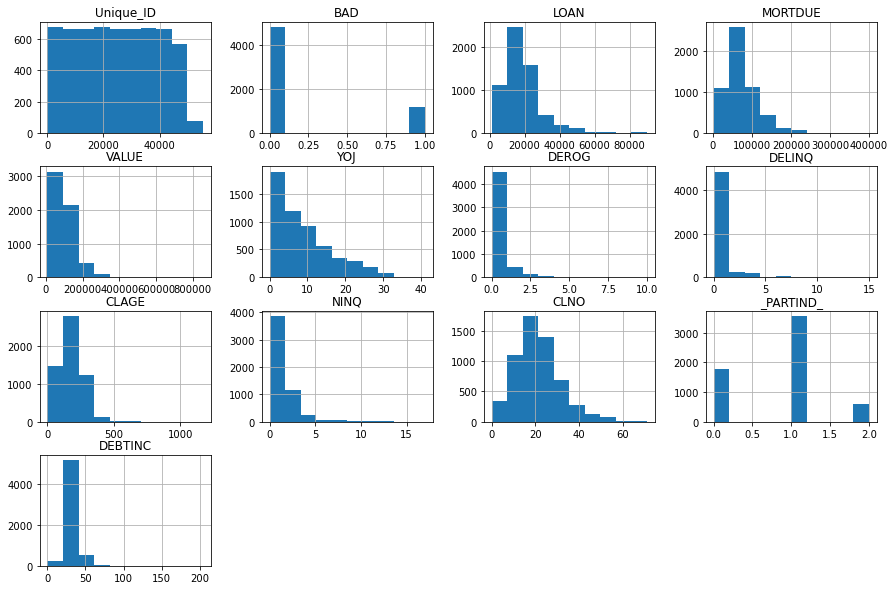

In [10]:
hists = df.hist(figsize = (15, 10))

### set variable shortcuts

In [13]:
# Define target variable
target = 'BAD'

# get categorical/numerical variables
input_vars = df.drop(target,axis=1).columns.values
kinds = np.array([dt.kind for dt in df.drop(target,axis=1).dtypes])

# Variable lists
categorical_vars = list(input_vars[kinds == 'O'])
numerical_vars = [i for i in list(input_vars[kinds != 'O']) if i not in ['Unique_ID','_PARTIND_']]
all_vars = categorical_vars + numerical_vars + [target]

### Prepare data for model

In [14]:
# Split into training and validation / target and inputs
X_train = df[df['_PARTIND_'] == 1].drop(target, axis = 1)
X_valid = df[df['_PARTIND_'] == 0].drop(target, axis = 1)
y_train = df[df['_PARTIND_'] == 1][target]
y_valid = df[df['_PARTIND_'] == 0][target]

## Build model - Scikit-learn

In [15]:
# Define data pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_vars),
    ('cat', categorical_transformer, categorical_vars)])

ml_pipe = Pipeline(steps=[
('preprocessor', preprocessor),
('model', GradientBoostingClassifier(random_state=3))])

fit = ml_pipe.fit(X_train, y_train)

### Assess model

In [16]:
# put results in pandas dataframe
results_df = pd.DataFrame(dict(actual = y_valid, pred = ml_pipe.predict_proba(X_valid)[:,1]))

# Predict and assess model
gb_y_score           = ml_pipe.predict(X_valid)
gb_misclassification = 1 - accuracy_score(y_valid, gb_y_score)
gb_confusion_matrix  = confusion_matrix(y_valid, gb_y_score)

# Add Python model results to CAS to assess
pytbl = s.upload_frame(results_df, casout=dict(name='GBT_sklearn_predictions', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table GBT_SKLEARN_PREDICTIONS in caslib Public.
NOTE: The table GBT_SKLEARN_PREDICTIONS has been created in caslib Public from binary data uploaded to Cloud Analytic Services.


In [17]:
gb_misclassification

0.10402684563758391

# Data Analysis on CAS

In [18]:
castbl.head()

Selected Rows from Table HMEQ_NEW

   Unique_ID  BAD    LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  _PARTIND_    DEBTINC
0      101.0  1.0  1100.0  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   94.366667   1.0   9.0        1.0  33.779915
1      201.0  1.0  1300.0  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0  121.833333   0.0  14.0        0.0  33.779915
2      301.0  1.0  1500.0  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0  149.466667   1.0  10.0        1.0  33.779915
3      401.0  1.0  1500.0      NaN       NaN                    NaN    NaN     NaN         NaN   NaN   NaN        1.0  33.779915
4      501.0  0.0  1700.0  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   93.333333   0.0  14.0        1.0  33.779915

## Data Exploration and Preparation - CAS

<ipython-input-19-3dd3bf3217b4>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

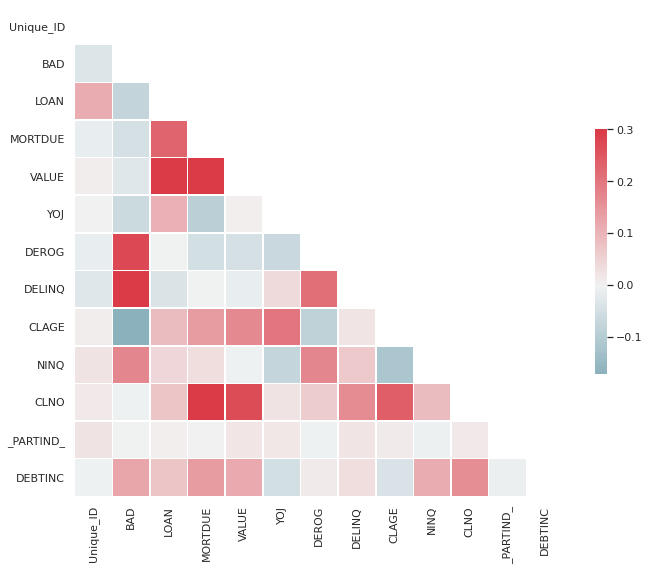

In [19]:
# Compute correlation matrix
corr = castbl.corr()

# Visualize with Seaborn
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Build models - CAS

In [20]:
import collections

# Models to be performed
models = collections.OrderedDict()
models['dt']  = 'Decision Tree'
models['gbt'] = 'Gradient Boosting'
models['nn']  = 'Neural Network'
models['svm'] = 'Support Vector Machine'

# Impute missing values
castbl.dataPreprocess.impute(
    outVarsNamePrefix = 'IMP',
    methodContinuous  = 'MEDIAN',
    methodNominal     = 'MODE',
    inputs            = categorical_vars + numerical_vars,
    copyAllVars       = True,
    casOut            = dict(name = 'hmeq_imputed', replace = True)
)
castbl_imp = s.CASTable('hmeq_imputed')

In [21]:
# Set key-word argument shortcuts (common model inputs)
## For models that can handle missing values (decision tree, gradient boosting)
params = dict(
    table    = dict(name = indata, where = '_PARTIND_ = 1'), 
    target   = target, 
    inputs   = categorical_vars + numerical_vars, 
    nominals = categorical_vars,
)

## For models that can't have missing values (neural network, support vector machine)
casinfo = castbl_imp.columninfo()['ColumnInfo']
imp_params = dict(
    table    = dict(name = 'hmeq_imputed', where = '_PARTIND_ = 1'), 
    target   = target, 
    inputs   = [x for x in list(casinfo['Column']) if x != target and ('IMP_' in x)], 
    nominals = [x for x in list(casinfo[casinfo.Type == 'varchar']['Column']) if x != target and ('IMP' in x)],
)

### Decision Tree - CAS

In [22]:
dt = s.decisionTree.dtreeTrain(**params, varImp = True, casOut = dict(name = 'dt_model', replace = True))

### Gradient Boosting - CAS

In [23]:
#s.dropTable('gradboost_astore')
gbt = s.decisionTree.gbtreeTrain(**params, seed = 5, casOut = dict(name = 'gbt_model', replace = True), savestate = 'gradboost_astore')

NOTE: 965643 bytes were written to the table "gradboost_astore" in the caslib "Public".


### Neural Network - CAS

In [24]:
nn = s.neuralNet.annTrain(**imp_params, seed = 1, casOut = dict(name = 'nn_model', replace = True))

### Support Vector Machine - CAS

In [25]:
svm = s.svm.svmTrain(**imp_params, seed = 1, kernel = 'polynomial', printtarget=True, id = ['_PARTIND_', 'Unique_ID'], savestate = dict(name = 'svm_model', replace = True))

NOTE: Reset degree to 2 for polynomial kernel.
NOTE: SVM training is activated.
NOTE: 9897 bytes were written to the table "svm_model" in the caslib "Public".


# Model Comparison

## Score the Models on Validation Data - CAS/Python

In [26]:
def score_model(model):
    score = dict(
        table      = 'hmeq_imputed',
        modelTable = model + '_model',
        copyVars   = [target, '_PARTIND_'],
        casOut     = dict(name = '_scored_' + model, replace = True),
        encodeName = True
    )
    return score

### Decision Tree
s.decisionTree.dtreeScore(**score_model('dt'))
### Gradient Boosting
s.decisionTree.gbtreeScore(**score_model('gbt'))
### Neural Network
s.neuralNet.annScore(**score_model('nn'))
### Support Vector Machine
svmscore = castbl_imp.astore.score(rstore = 'svm_model', out = dict(name = '_scored_svm_1', replace = True))

In [28]:
joined = s.CASTable('_scored_svm_1').merge(castbl_imp[['Unique_ID','BAD']],on='Unique_ID')
s.dropTable('_scored_svm', quiet='true')
s.table.altertable(name = joined.name, rename='_scored_svm')

+ Elapsed: 0.000343s, sys: 0.000263s, mem: 0.3mb

## Assess the Performance - CAS/Python

In [29]:
# Model assessment function
def assess_model(model):
    assess = s.percentile.assess(
        table    = dict(name = '_scored_' + model, where = '_PARTIND_ = 0'),
        inputs   = 'p_' + target,      
        response = target,
        event    = '1',
    )
    return assess

# Loop through the models and append to the roc_df dataframe
roc_df  = pd.DataFrame()
for i in range(len(models)):
    tmp = assess_model(list(models)[i])
    tmp.ROCInfo['Model'] = list(models.values())[i]
    roc_df = pd.concat([roc_df, tmp.ROCInfo])

## Compare Misclassification & ROC Curves - CAS/Python

In [30]:
# Assess the Python model using CAS
python_assess = pytbl.percentile.assess(
    inputs   = 'pred',      
    response = 'actual',
    event    = '1',   
)
python_assess.ROCInfo['Model'] = 'Gradient Boosting - sklearn'
roc_df['Model'] = roc_df['Model'] + ' - CAS'
roc_df = pd.concat([roc_df, python_assess.ROCInfo])
roc_df['Misclassification'] = 1 - roc_df['ACC']

print('\n', 'Misclassification Rate Comparison'.center(37, ' '))
miss = roc_df[round(roc_df['CutOff'], 2) == 0.5][['Model', 'Misclassification']].reset_index(drop = True)
miss.sort_values('Misclassification')


   Misclassification Rate Comparison  


Model  Misclassification
1       Gradient Boosting - CAS           0.096197
4   Gradient Boosting - sklearn           0.104027
0           Decision Tree - CAS           0.129195
3  Support Vector Machine - CAS           0.164430
2          Neural Network - CAS           0.165548

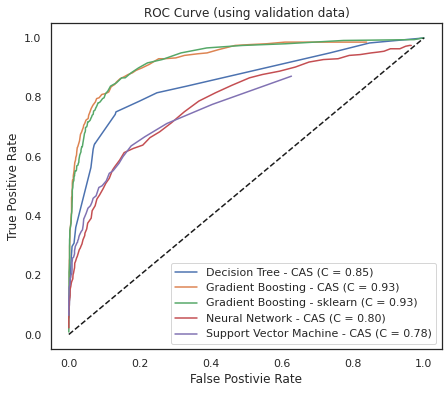

In [31]:
# Plot ROC curve
plt.figure(figsize = (7, 6))
for key, grp in roc_df.groupby(['Model']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label = key + ' (C = %0.2f)' % grp['C'].mean())
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve (using validation data)');

## Automated Machine Learning

## dsAutoML - CAS

In [32]:
s.loadactionset('dataSciencePilot')
trans_out = dict(name = 'trans_out', replace=True)
feat_out = dict(name = 'feat_out', replace=True)
pipeline_out = dict(name = 'pipeline_out', replace=True)
#save_state_out = dict(name = 'save_state_out', replace=True)
automl_model = dict(name = 'automl_model', replace=True) 

NOTE: Added action set 'dataSciencePilot'.


In [33]:
s.dataSciencePilot.dsAutoMl(table=castbl, target=target,
                            modelTypes=["DECISIONTREE", "FOREST", "GRADBOOST", "NEURALNET"], 
                            transformationOut = trans_out,
                            featureOut = feat_out,
                            pipelineOut = pipeline_out,
                            saveState = automl_model)

NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'neuralNet'.


[ModelInfo_1_DecisionTree]

 Decision Tree for __TEMP_FEATURE_MACHINE_CASOUT___AUTOTUNE_30NOV2021:09:51:25
 
                            Descr        Value
 0           Number of Tree Nodes   161.000000
 1         Max Number of Branches     2.000000
 2               Number of Levels    15.000000
 3               Number of Leaves    81.000000
 4                 Number of Bins   100.000000
 5         Minimum Size of Leaves     5.000000
 6         Maximum Size of Leaves  2021.000000
 7            Number of Variables    11.000000
 8   Confidence Level for Pruning     0.250000
 9    Number of Observations Used  5960.000000
 10   Misclassification Error (%)    11.409396

[ScoreInfo_1_DecisionTree]

                          Descr                             Value
 0  Number of Observations Read                              5960
 1  Number of Observations Used                              5960
 2  Misclassification Error (%)                      11.409395973

[EncodedName_1_DecisionTree]

         LEVNAME  LEVINDEX VARNAME
 0             1         0  P_BAD1
 1             0         1  P_BAD0

[EncodedTargetName_1_DecisionTree]

   LEVNAME  LEVINDEX VARNAME
 0                 0   I_BAD

[ROCInfo_1_DecisionTree]

 ROC Information for _AUTOTUNE_DEFAULT_SCORE_TABLE_
 
    Variable Event  CutOff      TP      FP      FN      TN  Sensitivity  Specificity   KS       KS2    F_HALF       FPR       ACC       FDR        F1         C      Gini     Gamma       Tau  MISCEVENT
 0    P_BAD0     0    0.00  4771.0  1189.0     0.0     0.0     1.000000     0.000000  0.0  0.000000  0.833770  1.000000  0.800503  0.199497  0.889200  0.892568  0.785136  0.865997  0.250811   0.199497
 1    P_BAD0     0    0.01  4771.0   930.0     0.0   259.0     1.000000     0.217830  0.0  0.217830  0.865095  0.782170  0.843960  0.163129  0.911192  0.892568  0.785136  0.865997  0.250811   0.156040
 2    P_BAD0     0    0.02  4771.0   930.0     0.0   259.0     1.000000     0.217830  0.0  0.217830  0.865095  0.782170  0.843960  0.163129  0.911192  0.892568  0.785136  0.865997  0.250811   0.156040
 3    P_BAD0     0    0.03  4771.0   930.0     0.0   259.0     1.000000     0.217830  0.0  0.217830  0.865095  0.782170  0.843960  0.163129  0.911192  0.892568  0.785136  0.865997  0.250811   0.156040
 4    P_BAD0     0    0.04  4771.0   930.0     0.0   259.0     1.000000     0.217830  0.0  0.217830  0.865095  0.782170  0.843960  0.163129  0.911192  0.892568  0.785136  0.865997  0.250811   0.156040
 5    P_BAD0     0    0.05  4771.0   930.0     0.0   259.0     1.000000     0.217830  0.0  0.217830  0.865095  0.782170  0.843960  0.163129  0.911192  0.892568  0.785136  0.865997  0.250811   0.156040
 6    P_BAD0     0    0.06  4770.0   913.0     1.0   276.0     0.999790     0.232128  0.0  0.231918  0.867178  0.767872  0.846644  0.160655  0.912569  0.892568  0.785136  0.865997  0.250811   0.153356
 7    P_BAD0     0    0.07  4770.0   913.0     1.0   276.0     0.999790     0.232128  0.0  0.231918  0.867178  0.767872  0.846644  0.160655  0.912569  0.892568  0.785136  0.865997  0.250811   0.153356
 8    P_BAD0     0    0.08  4770.0   913.0     1.0   276.0     0.999790     0.232128  0.0  0.231918  0.867178  0.767872  0.846644  0.160655  0.912569  0.892568  0.785136  0.865997  0.250811   0.153356
 9    P_BAD0     0    0.09  4770.0   913.0     1.0   276.0     0.999790     0.232128  0.0  0.231918  0.867178  0.767872  0.846644  0.160655  0.912569  0.892568  0.785136  0.865997  0.250811   0.153356
 10   P_BAD0     0    0.10  4770.0   913.0     1.0   276.0     0.999790     0.232128  0.0  0.231918  0.867178  0.767872  0.846644  0.160655  0.912569  0.892568  0.785136  0.865997  0.250811   0.153356
 11   P_BAD0     0    0.11  4770.0   913.0     1.0   276.0     0.999790     0.232128  0.0  0.231918  0.867178  0.767872  0.846644  0.160655  0.912569  0.892568  0.785136  0.865997  0.250811   0.153356
 12   P_BAD0     0    0.12  4770.0   913.0     1.0   276.0     0.999790     0.232128  0.0  0.231918  0.867178

In [34]:
s.fetch(table='pipeline_out', to=3)

[Fetch]

 Selected Rows from Table PIPELINE_OUT
 
    PipelineId              ModelType     MLType  Objective ObjectiveType Target  NFeatures  Feat1Id  Feat1IsNom  Feat2Id  Feat2IsNom  Feat3Id  Feat3IsNom  Feat4Id  Feat4IsNom  Feat5Id  Feat5IsNom  Feat6Id  Feat6IsNom  Feat7Id  Feat7IsNom  Feat8Id  Feat8IsNom  Feat9Id  Feat9IsNom  Feat10Id  Feat10IsNom  Feat11Id  Feat11IsNom  Feat12Id  Feat12IsNom  Feat13Id  Feat13IsNom
 0         3.0  binary classification  gradBoost   0.088367           MCE    BAD       13.0     31.0         1.0     12.0         0.0     33.0         1.0     38.0         0.0     39.0         1.0      4.0         1.0     22.0         1.0     30.0         1.0     18.0         0.0      41.0          1.0      15.0          1.0      14.0          1.0      42.0          1.0
 1         7.0  binary classification  gradBoost   0.092841           MCE    BAD       10.0     31.0         1.0     12.0         0.0     33.0         1.0     38.0         0.0     40.0         1.0      3.0         1.0     26.0         0.0     30.0         1.0     18.0         0.0      41.0          1.0       NaN          NaN       NaN          NaN       NaN          NaN
 2         6.0  binary classification     forest   0.106264           MCE    BAD       10.0     31.0         1.0     12.0         0.0     33.0         1.0     38.0         0.0     40.0         1.0      3.0         1.0     26.0         0.0     30.0         1.0     18.0         0.0      41.0          1.0       NaN          NaN       NaN          NaN       NaN          NaN

+ Elapsed: 0.00157s, user: 0.00142s, sys: 0.000105s, mem: 0.997mb

# Register Model

## Add model to repository - CAS

In [6]:
from sasctl import Session, register_model
from sasctl.services import model_repository

In [36]:
astore = s.CASTable('gradboost_astore')

In [37]:
astore

CASTable('gradboost_astore')

In [38]:
with Session('http://frasepviya35smp.cloud.com', 'viyademo01', 'demopw'):
    register_model(astore, 'GBT Model swat', 'HMEQ_Modeling')

NOTE: Added action set 'astore'.
NOTE: Cloud Analytic Services saved the file _2DE37852F2C84341A17E78D84.sashdat in caslib ModelStore.


In [42]:
model = ml_pipe
with Session('http://frasepviya35smp.cloud.com', 'viyademo01', 'demopw'):
    register_model(model, 'GBT Model sklearn', '4. Manage churn models')

In [8]:
with Session('http://frasepviya35smp.cloud.com', 'viyademo01', 'demopw'):
    models = model_repository.list_models()

In [9]:
models

[<class 'sasctl.core.RestObj'>(headers={}, data={'creationTimeStamp': '2021-11-26T08:43:21.572Z', 'modifiedTimeStamp': '2021-11-26T08:47:33.872Z', 'createdBy': 'viyademo01', 'modifiedBy': 'viyademo01', 'links': [{'method': 'GET', 'rel': 'self', 'href': '/modelRepository/models/7fc6b955-32e9-4327-bf6f-8f82245b7721', 'uri': '/modelRepository/models/7fc6b955-32e9-4327-bf6f-8f82245b7721', 'type': 'application/vnd.sas.models.model'}, {'method': 'DELETE', 'rel': 'delete', 'href': '/modelRepository/models/7fc6b955-32e9-4327-bf6f-8f82245b7721', 'uri': '/modelRepository/models/7fc6b955-32e9-4327-bf6f-8f82245b7721'}, {'method': 'GET', 'rel': 'contents', 'href': '/modelRepository/models/7fc6b955-32e9-4327-bf6f-8f82245b7721/contents', 'uri': '/modelRepository/models/7fc6b955-32e9-4327-bf6f-8f82245b7721/contents', 'type': 'application/vnd.sas.collection', 'itemType': 'application/vnd.sas.models.model.content.summary'}, {'method': 'GET', 'rel': 'variables', 'href': '/modelRepository/models/7fc6b955-

In [10]:
s.close()